## **OKCupid Date-a-Scientist**

### Scope

In recent years, there has been a massive rise in the usage of dating apps to find love. Many of these apps use sophisticated data science techniques to recommend possible matches to users and to optimize the user experience. These apps give us access to a wealth of information that we’ve never had before about how different people experience romance.

The focus of this project is predicting the zodiac sign of the users. Zodiac symbols are important for many users, but some users don’t add them in. This way, we can predict a user’s zodiac signs so we can guess the missing zodiacs when we make matches.

### Introduction

First, necessary libraries are imported and the data is loaded and previewed.

In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from preprocessing import preprocess_text
from scipy.sparse import hstack
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV


df = pd.read_csv('profiles.csv')
df.head()

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...",...,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,...,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,...,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,...,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
4,29,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,...,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single


Next, we can have a look at the basic information and missing values (not considering essay questions).

In [121]:
df.drop(columns = df.loc[:,'essay0':'essay9'].columns).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   body_type    54650 non-null  object 
 2   diet         35551 non-null  object 
 3   drinks       56961 non-null  object 
 4   drugs        45866 non-null  object 
 5   education    53318 non-null  object 
 6   ethnicity    54266 non-null  object 
 7   height       59943 non-null  float64
 8   income       59946 non-null  int64  
 9   job          51748 non-null  object 
 10  last_online  59946 non-null  object 
 11  location     59946 non-null  object 
 12  offspring    24385 non-null  object 
 13  orientation  59946 non-null  object 
 14  pets         40025 non-null  object 
 15  religion     39720 non-null  object 
 16  sex          59946 non-null  object 
 17  sign         48890 non-null  object 
 18  smokes       54434 non-null  object 
 19  spea

### Data Cleaning

We can see that there are some essay questions that are more suitable for NLP approach and modeling. We will separate these questions to another data frame and return to it later.

In [122]:
df_essay = df.loc[:,'essay0':'essay9']
df.drop(columns = df.loc[:,'essay0':'essay9'].columns, inplace = True)

Now, we can inspect some columns that may have a majority of `NaN` or not specified values (like `income` and `offspring`). In order to clean up the data, we can remove these columns along with the columns that may not be important for predicting the zodiac sign.

In [123]:
print(df.offspring.value_counts(dropna = False))
# print(df.income.value_counts(dropna = False))
# print(df.offspring.value_counts(dropna = False))

df.drop(columns = ['income','offspring','age','ethnicity','height','last_online','location','speaks'], inplace = True)
df.head()

NaN                                                    35561
doesn&rsquo;t have kids                                 7560
doesn&rsquo;t have kids, but might want them            3875
doesn&rsquo;t have kids, but wants them                 3565
doesn&rsquo;t want kids                                 2927
has kids                                                1883
has a kid                                               1881
doesn&rsquo;t have kids, and doesn&rsquo;t want any     1132
has kids, but doesn&rsquo;t want more                    442
has a kid, but doesn&rsquo;t want more                   275
has a kid, and might want more                           231
wants kids                                               225
might want kids                                          182
has kids, and might want more                            115
has a kid, and wants more                                 71
has kids, and wants more                                  21
Name: offspring, dtype: 

,body_type,diet,drinks,drugs,education,job,orientation,pets,religion,sex,sign,smokes,status
0,a little extra,strictly anything,socially,never,working on college/university,transportation,straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,single
1,average,mostly other,often,sometimes,working on space camp,hospitality / travel,straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,single
2,thin,anything,socially,NaN,graduated from masters program,NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,available
3,thin,vegetarian,socially,NaN,working on college/university,student,straight,likes cats,NaN,m,pisces,no,single
4,athletic,NaN,socially,never,graduated from college/university,artistic / musical / writer,straight,likes dogs and likes cats,NaN,m,aquarius,no,single


We can see that `sign` and `religion` have pretty messy values. We can separate the religion/sign into one column and the rest in the second. Also, we have to fill the `NaN` values for the comments that were not inputted.

In [124]:
# replacing the html special characters for colon
df['sign'] = df.sign.replace({'&rsquo;':'\''},regex = True)

# splitting the sign column
df['zodiac'] = df.sign.str.split(' ').str.get(0)
df['zodiac_comment'] = df.sign.str.split(' ',1).str.get(1)
df['zodiac_comment'] = df['zodiac_comment'].fillna('None') 

# splitting the religion column
df['religion_comment'] = df.religion.str.split(' ',1).str.get(1)
df['religion'] = df.religion.str.split(' ').str.get(0)
df['religion_comment'] = df['religion_comment'].fillna('None') 

df.drop(columns=['sign'],inplace = True)
print(df.zodiac.value_counts())

leo            4374
gemini         4310
libra          4207
cancer         4206
virgo          4141
taurus         4140
scorpio        4134
aries          3989
pisces         3946
sagittarius    3942
aquarius       3928
capricorn      3573
Name: zodiac, dtype: int64


### **Exploratory Data Analisys**

As we cleaned the two categories above, we can see that there are only 12 zodiac signs and certain religions. Also, zodiac signs are distributed evenly.
Next, we can show the variation in sex across different categorical variables. The fields `education` and `job` have too many distinct variables and are therefore not plotted. As we can see, some variables like `drinks`, `drugs`, `smokes` etc. are ordinal variables nd will later be mapped to integer values.

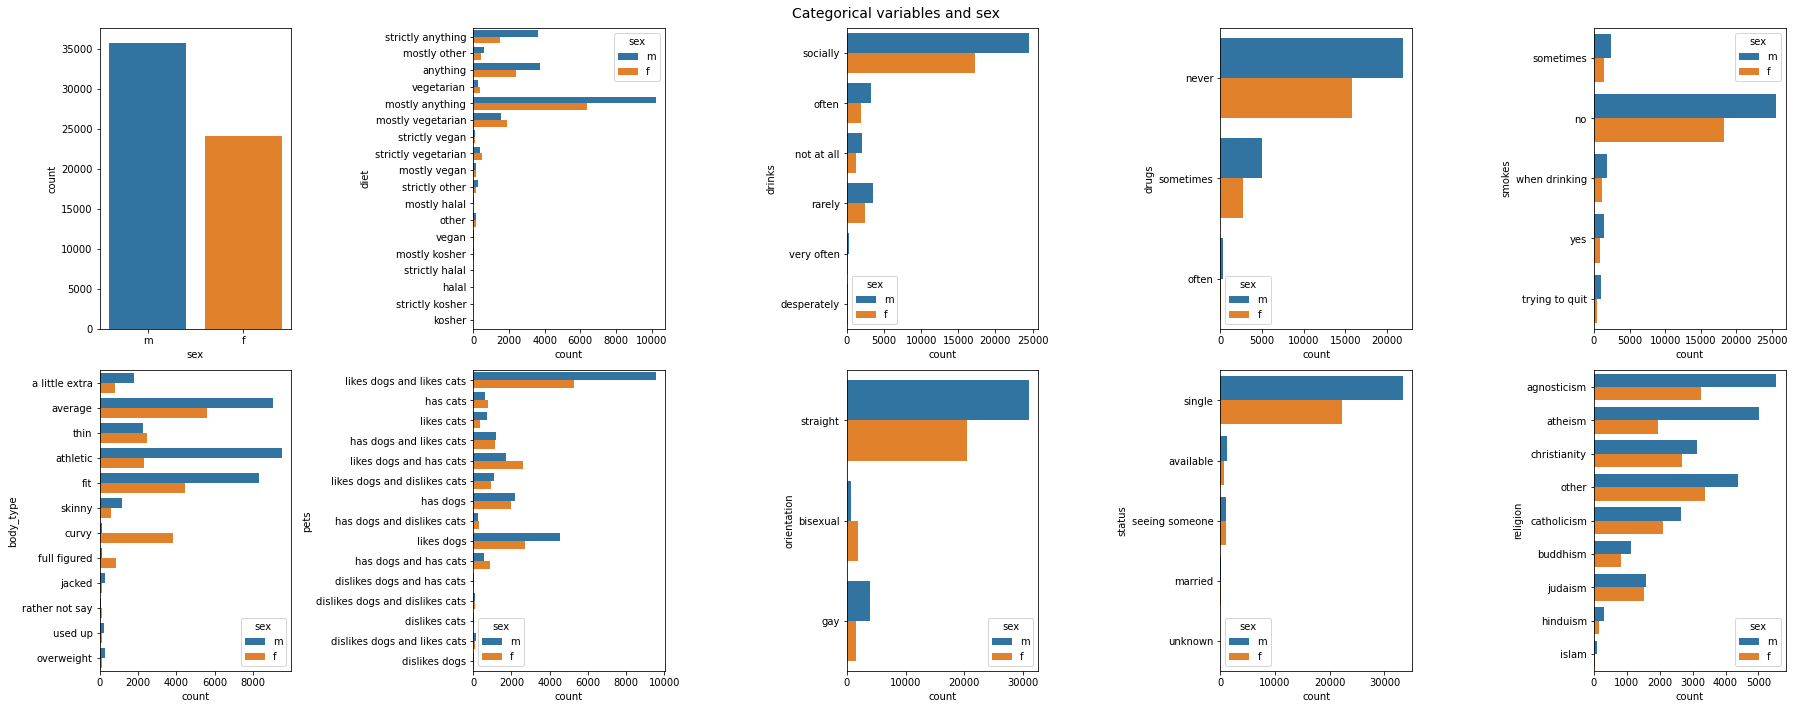

In [125]:
fig,axes=plt.subplots(2,5,figsize=(25,10))

sns.countplot(data = df, x ='sex',ax=axes[0,0])
sns.countplot(y="diet",hue="sex",data=df,ax=axes[0,1])
sns.countplot(y="drinks",data=df, hue = 'sex',ax=axes[0,2])
sns.countplot(y="drugs",hue="sex",data=df,ax=axes[0,3])
sns.countplot(y="smokes",hue="sex",data=df,ax=axes[0,4])

sns.countplot(y="body_type",hue="sex",data=df,ax=axes[1,0])
sns.countplot(y="pets",hue="sex",data=df,ax=axes[1,1])
sns.countplot(y="orientation",data=df, hue = 'sex',ax=axes[1,2])
sns.countplot(y="status",hue="sex",data=df,ax=axes[1,3])
sns.countplot(y="religion",hue="sex",data=df,ax=axes[1,4])

plt.suptitle("Categorical variables and sex",fontsize=14)
plt.tight_layout()

# print(df.job.value_counts())
# print(df.education.value_counts())

### **Data Preprocessing**

Now, we can start with the data preprocessing. First, we can map the certain columns like `drinks` and `drugs` to integers.

In [126]:
df['drinks'] = df.drinks.replace({'not at all':0,'rarely':1,'socially':2, 'often':3,'very often':4,'desperately':5})
df['drugs'] = df.drugs.replace({'never':0,'sometimes':1,'often':2})
df['smokes'] = df.smokes.replace({'no':0, 'trying to quit':1, 'when drinking':2,'sometimes':3, 'yes':4})

print(df.drugs.value_counts())
print(df.smokes.value_counts())

0.0    37724
1.0     7732
2.0      410
Name: drugs, dtype: int64
0.0    43896
3.0     3787
2.0     3040
4.0     2231
1.0     1480
Name: smokes, dtype: int64


Label encoder

<AxesSubplot:>

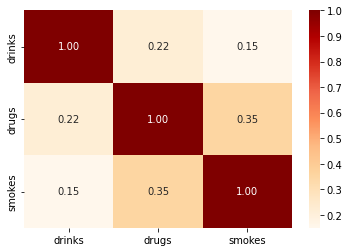

In [127]:
sns.heatmap(df.corr(),cmap='OrRd',annot=True,fmt=".2f")

### Preprocessing text data

Essay questions have to be preprocessed first. This involves removing punctuation, URLs and stop words, lower casing and finally tokenization, stemming and lematization. This is all done using the `preprocess_text` function that uses `nltk` library. Since there are some `Nan` values, we have to replace them with empty strings first.

In [9]:
print(df_essay.isna().sum())
df_essay.fillna('Nan',inplace = True)

df_essay = df_essay.applymap(lambda x: preprocess_text(x))
df_essay.head(5)

essay0     5488
essay1     7572
essay2     9638
essay3    11476
essay4    10537
essay5    10850
essay6    13771
essay7    12451
essay8    19225
essay9    12603
dtype: int64


,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,about me br br i would love to think that i be...,currently work a an international agent for a ...,make people laugh br ranting about a good salt...,the way i look i be a six foot half asian half...,book br absurdistan the republic of mouse and ...,food br water br cell phone br shelter,duality and humorous thing,try to find someone to hang out with i be down...,i be new to california and look for someone to...,you want to be sweep off your foot br you be t...
1,i be a chef this be what that mean br i be a w...,dedicate everyday to be an unbelievable badass,be silly have ridiculous amonts of fun whereve...,nan,i be die hard christopher moore fan i don t re...,delicious porkness in all of it glory br my bi...,nan,nan,i be very open and will share just about anything,nan
2,i m not ashamed of much but write public text ...,i make nerdy software for musician artist and ...,improvise in different context alternate betwe...,my large jaw and large glass be the physical t...,okay this be where the cultural matrix get so ...,movement br conversation br creation br contem...,nan,view listen dance talk drink perform,when i be five year old i be know a the boogerman,you be bright open intense silly ironic critic...
3,i work in a library and go to school,read thing write by old dead people,play synthesizer and organize book accord to t...,socially awkward but i do my best,bataille celine beckett br lynch jarmusch r w ...,nan,cat and german philosophy,nan,nan,you feel so incline
4,hey how s it go currently vague on the profile...,work work work work play,create imagery to look at br http bagsbrown bl...,i smile a lot and my inquisitive nature,music band rapper musician br at the moment th...,nan,nan,nan,nan,nan


### Missing Values

Now, we can merge the processed text data with the rest of the features and deal with the missing data.


In [128]:
# add essay questions
df = pd.concat([df,df_essay],axis = 1)


#  null_df = df.isnull().sum().sort_values(ascending=False).reset_index().rename(columns={'index':'feature', 0:'count'})
# null_df['percentage'] = null_df.apply(lambda row: row['count']/len(df), axis=1)
# null_df

df.dropna(inplace = True)

### Select features, split and standardize data

In this section, we can choose different features and iteratively find the best combination of features by checking the results of different ML models with various features. The data is split into training and test data.

In [129]:

# Select the desired features
essay_questions = False
features_list = ['smokes',\
                'drinks',\
                'drugs',\
                'body_type',\
                'diet',\
                # 'religion',\
                # 'job',\
                # 'education',\
                # 'pets',\
                # 'orientation',\
                # 'sex',\
                # 'status',\
                ]

# list of variables that need to be encoded
categorical_features_list = features_list[3:]

# take the selected features and make dummy variables
cat_features = df[features_list]
cat_features = pd.get_dummies(cat_features, columns=categorical_features_list)

# add categoricals with dummies and essay questions
if essay_questions:
    features = pd.concat([cat_features,df.loc[:,'essay0':'essay9']],axis = 1)
else:
    features = cat_features

zodiac = df.zodiac
# check label imbalance
print(zodiac.value_counts())

# Perform train and test split
X_train, X_test,y_train, y_test = train_test_split(features,zodiac, test_size = 0.2)

cancer         706
leo            690
virgo          688
gemini         675
aries          665
libra          650
taurus         643
sagittarius    631
scorpio        622
aquarius       605
pisces         590
capricorn      555
Name: zodiac, dtype: int64


As seen, we checked whether the labels are imbalanced, which is not the case.

#### Feature vectors of the text data

Next, we have to vectorize the text data using the bag of words model. Because the vectorizer can take only one column at the time, we have to get the feature vectors of each column separately and merge them together with the rest of the features. The whole data is then standardized for the models that require standardization.

In [130]:
if essay_questions:
    # set final data matrices
    training_data = X_train[list(cat_features.columns)].values
    test_data = X_test[list(cat_features.columns)].values

    # get feature vectors for each essay column and join them together
    for column in list(X_train.loc[:,'essay0':'essay9'].columns):
        # innitialize CountVectorizer for each column
        cv = CountVectorizer(stop_words = 'english')

        # fit the vectorizer and transform training data
        X_train_cv = cv.fit_transform(X_train[column])
        # merge the vector with others
        training_data = hstack((training_data, X_train_cv))

        # transform and merge the test data
        X_test_cv = cv.transform(X_test[column])
        test_data = hstack((test_data, X_test_cv))
else:
    training_data = X_train
    test_data = X_test

# set label data
training_labels = y_train
test_labels = y_test


# Scale the feature data so it has mean = 0 and standard deviation = 1
stdScaler = StandardScaler(with_mean=False)
X_train_sc = stdScaler.fit(training_data)
X_train_std = X_train_sc.transform(training_data)
X_test_std = X_train_sc.transform(test_data)

### **Machine Learning Models**

We can test various models and compare the results for the same set of data.

#### Naive Bayes Classifier

In [131]:
# Naive Bayes Classifier
zodiac_classifier = MultinomialNB()

# create and fit Naive Bayes Classifier
zodiac_classifier.fit(training_data, training_labels)

# Kfold cross validation
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(zodiac_classifier, training_data, training_labels, cv=kfold, scoring='accuracy')

print('KFold results:',results)
print("Average: %.2f%%" % (results.mean()*100))

# see the accuracy
print()
print(f'Naive Bayes model score: {zodiac_classifier.score(test_data,y_test)}')

KFold results: [0.08737864 0.08825911 0.08987854 0.09473684 0.08825911]
Average: 8.97%

Naive Bayes model score: 0.08678756476683938


#### Logistic Regression

In [132]:
# Create and train the model
LRmodel = LogisticRegression(multi_class="multinomial", max_iter=200) 

# make pipeline to scale each fold of the data
clf = make_pipeline(StandardScaler(), LRmodel)

# Kfold cross validation
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(clf, training_data, training_labels, cv=kfold, scoring='accuracy')

print('KFold results:',results)
print("Average: %.2f%%" % (results.mean()*100))

# Score the model on the test data
LRmodel.fit(X_train_std,training_labels)
print()
print(f'Logistic Regression model score: {LRmodel.score(X_test_std,y_test)}')

KFold results: [0.08009709 0.08987854 0.07935223 0.08987854 0.07935223]
Average: 8.37%

Logistic Regression model score: 0.08678756476683938


#### K-Neighbors Classifier

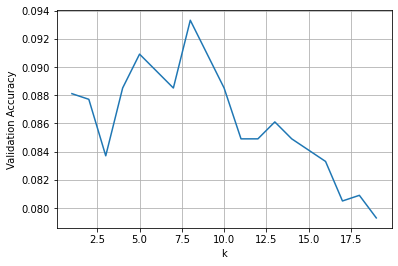

K-Neighbors model score: 0.08850620744893872


In [57]:
# choose the best value of k
accuracies = []
i = 20
for k in range(1,i):
  classifier = KNeighborsClassifier(k)
  classifier.fit(X_train_std,y_train)
  accuracies.append(classifier.score(X_test_std,y_test))
klist = range(1,i)

plt.plot(klist,accuracies)
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.grid()
plt.show()

k = 10

# fit the model
model2 = KNeighborsClassifier(k)
model2.fit(X_train_std,y_train)

print(f'K-Neighbors model score: {model2.score(X_test_std,y_test)}')

#### SVM

In [134]:
# # check for the best parameters
tuned_parameters = [
  {'C': [1, 10, 100, 1000], 'kernel': ['rbf']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

SVCclf = GridSearchCV(SVC(), tuned_parameters, scoring ='accuracy')
SVCclf.fit(X_train, y_train)

print("Best parameters set found on validation set:")
print()
print(SVCclf.best_params_)
print()
print("Grid scores on development set:")
print()
# means = SVCclf.cv_results_["mean_test_score"]
# stds = SVCclf.cv_results_["std_test_score"]
# for mean, std, params in zip(means, stds, SVCclf.cv_results_["params"]):
#   print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

# see the score
print(f'SVC model score: {SVCclf.score(X_test_std,y_test)}')

Best parameters set found on validation set:

{'C': 10, 'kernel': 'rbf'}
Grid scores on development set:

0.089 (+/-0.010) for {'C': 1, 'kernel': 'rbf'}
0.092 (+/-0.011) for {'C': 10, 'kernel': 'rbf'}
0.085 (+/-0.014) for {'C': 100, 'kernel': 'rbf'}
0.085 (+/-0.006) for {'C': 1000, 'kernel': 'rbf'}
0.091 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.091 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.091 (+/-0.019) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.091 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.091 (+/-0.009) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.090 (+/-0.019) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.090 (+/-0.009) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.090 (+/-0.010) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}


c:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


SVC model score: 0.0822538860103627


#### Decision tree

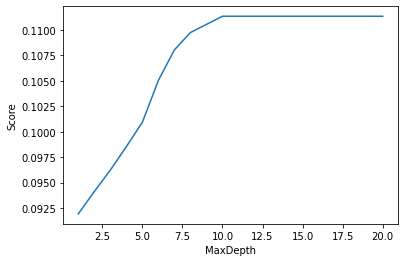

Decision tree model score: 0.08930716860232278


In [ ]:
# choose the best depth of the tree
score = []
maxDepth = 21
for i in range(1,maxDepth):

  # create and fir decision tree
  tree = DecisionTreeClassifier(random_state = 1, max_depth = i)

  tree.fit(X_train,y_train)
  score.append(tree.score(X_train,y_train))
  # print(score)

# plot results
plt.plot(range(1,maxDepth),score)
plt.xlabel('MaxDepth')
plt.ylabel('Score')
plt.show()

# train again with the best depth
bestDepth = 14
tree = DecisionTreeClassifier(max_depth = bestDepth)
tree.fit(X_train,y_train)

# see the score
print(f'Decision tree model score: {tree.score(X_test,y_test)}')

#### Random Forest Classifier

In [39]:
# create and fit random forest
forest = RandomForestClassifier()
forest.fit(training_data,y_train)

# print accuracy score
print(f'Random forest model score: {forest.score(test_data,y_test)}')

Random forest model score: 0.0841009211053264


#### XGBoost

### **Conclusion**

It can be seen that the best score was not better than the random guess (1/12), combining all of the given data. This draws the question of the predictability of the zodiac signs. What does the zodiac sign depend on? According to the results, it is nothing from the given data. Actually, the results are probably as expected, at least for the person who gives no special connection to zodiac sign and everyday life.